Name: Riddham Gadia

USC ID: 8030319068

Github Id: RiddhamGadia

In [47]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import cv2
import warnings
warnings.filterwarnings('ignore')
from random import sample
import math
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout,BatchNormalization,Activation
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import EfficientNetB0
from keras.preprocessing.image import ImageDataGenerator
import splitfolders
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [5]:
# pip install split-folders

### Splitting into train, validation and  test folders

In [6]:
splitfolders.ratio("../Data/Sport Images",'../Data/output',seed=1337,ratio=(0.7,0.15,0.15),group_prefix=None, move=False) 

Copying files: 3282 files [01:18, 41.95 files/s]


### Augmenting the Image and Generating the train data

In [7]:
train_datagen=ImageDataGenerator(zoom_range=0.2,brightness_range=(0.2,0.7),horizontal_flip=True,vertical_flip=True,rotation_range=0.2)
train_values=train_datagen.flow_from_directory('../Data/output/train',target_size=(224,224),batch_size=5,class_mode='categorical',shuffle=True)

Found 2284 images belonging to 5 classes.


### Generating the validation data 

In [8]:
validation_datagen=ImageDataGenerator()
val_values=validation_datagen.flow_from_directory('../Data/output/val',target_size=(224,224),batch_size=5,class_mode='categorical',shuffle=False)

Found 485 images belonging to 5 classes.


### Generating the test data

In [9]:
test_datagen=ImageDataGenerator()
test_values=test_datagen.flow_from_directory('../Data/output/test',target_size=(224,224),batch_size=5,class_mode='categorical',shuffle=False)

Found 495 images belonging to 5 classes.


### VGG16 Model

In [10]:
vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))

vgg16.trainable=False

model = tf.keras.models.Sequential([
        vgg16,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1024, activation ='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(5, activation='softmax')
])

58889256/58889256 [==============================] - 4s 0us/step


In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [12]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=['accuracy',Precision(),Recall()])

In [13]:
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10, restore_best_weights=True)

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 batch_normalization (BatchN  (None, 25088)            100352    
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4096      
 hNormalization)                                        

In [15]:
clf=model.fit(train_values,epochs=100,callbacks=[early_stop],validation_data=(val_values),batch_size=5)

Epoch 1/100
457/457 [==============================] - 62s 109ms/step - loss: 1.7214 - accuracy: 0.6090 - precision: 0.6242 - recall: 0.5906 - val_loss: 2.9248 - val_accuracy: 0.7010 - val_precision: 0.7025 - val_recall: 0.7010
Epoch 2/100
457/457 [==============================] - 48s 105ms/step - loss: 0.8958 - accuracy: 0.7045 - precision: 0.7403 - recall: 0.6826 - val_loss: 2.4148 - val_accuracy: 0.7155 - val_precision: 0.7169 - val_recall: 0.7155
Epoch 3/100
457/457 [==============================] - 48s 104ms/step - loss: 0.7260 - accuracy: 0.7351 - precision: 0.7749 - recall: 0.7023 - val_loss: 2.5777 - val_accuracy: 0.7134 - val_precision: 0.7203 - val_recall: 0.7113
Epoch 4/100
457/457 [==============================] - 47s 103ms/step - loss: 0.7032 - accuracy: 0.7715 - precision: 0.7940 - recall: 0.7408 - val_loss: 2.7363 - val_accuracy: 0.7299 - val_precision: 0.7308 - val_recall: 0.7278
Epoch 5/100
457/457 [==============================] - 49s 107ms/step - loss: 0.6499 - a

### Plots for VGG16

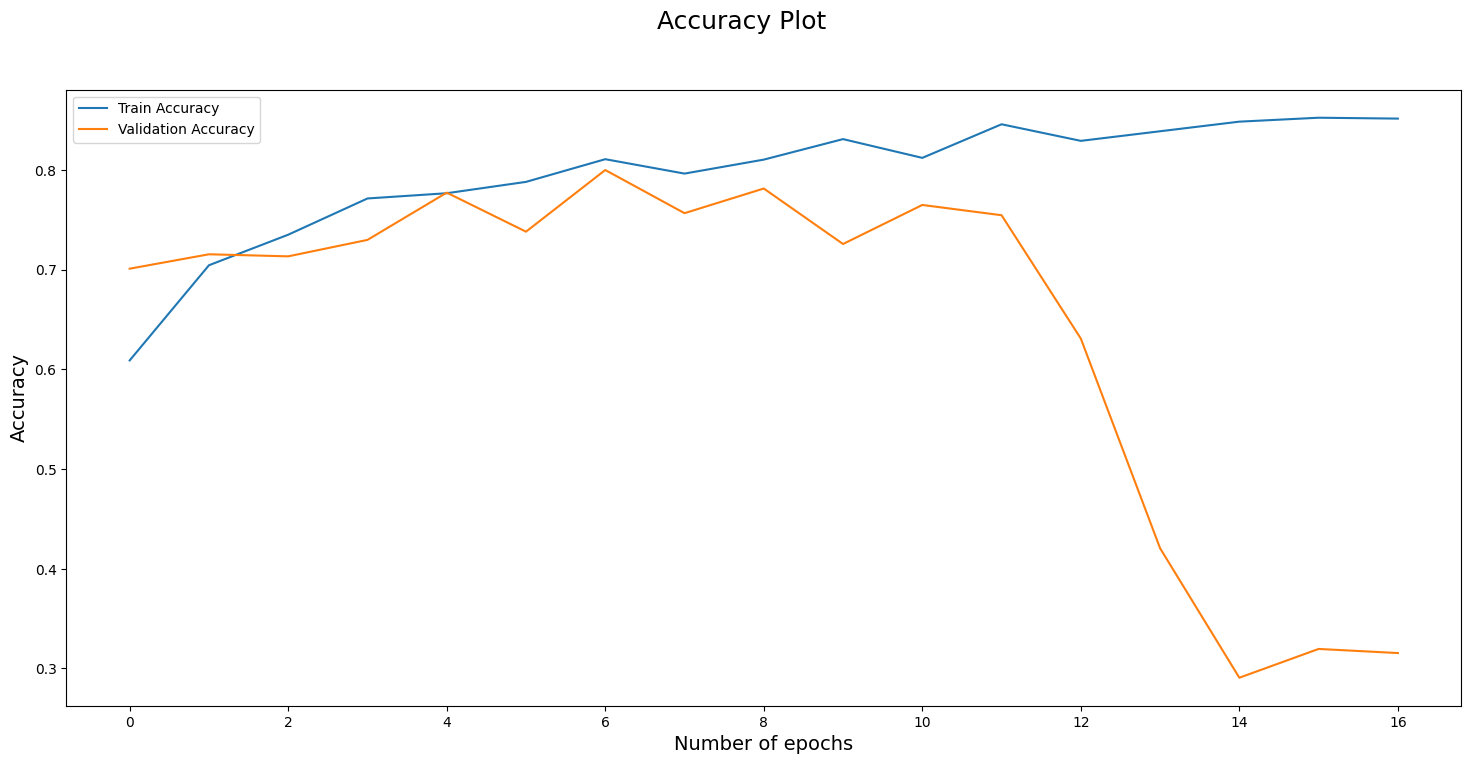

In [16]:
plt.figure(figsize=(18,8))

plt.suptitle('Accuracy Plot', fontsize=18)

plt.plot(clf.history['accuracy'], label='Train Accuracy')
plt.plot(clf.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Number of epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.show()


Text(0, 0.5, 'Loss')

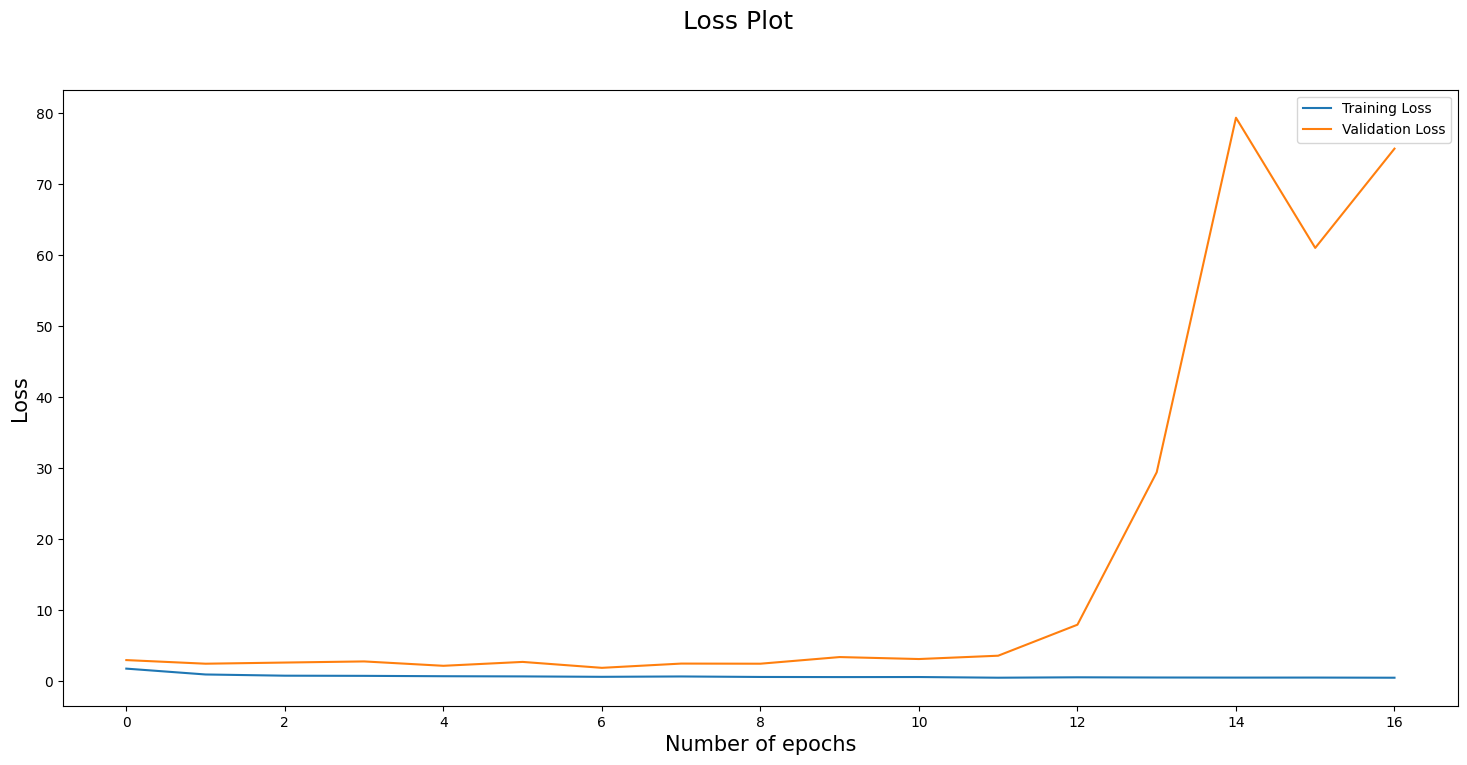

In [17]:
plt.figure(figsize=(18,8))

plt.suptitle('Loss Plot', fontsize=18)
plt.plot(clf.history['loss'], label='Training Loss')
plt.plot(clf.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Number of epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)


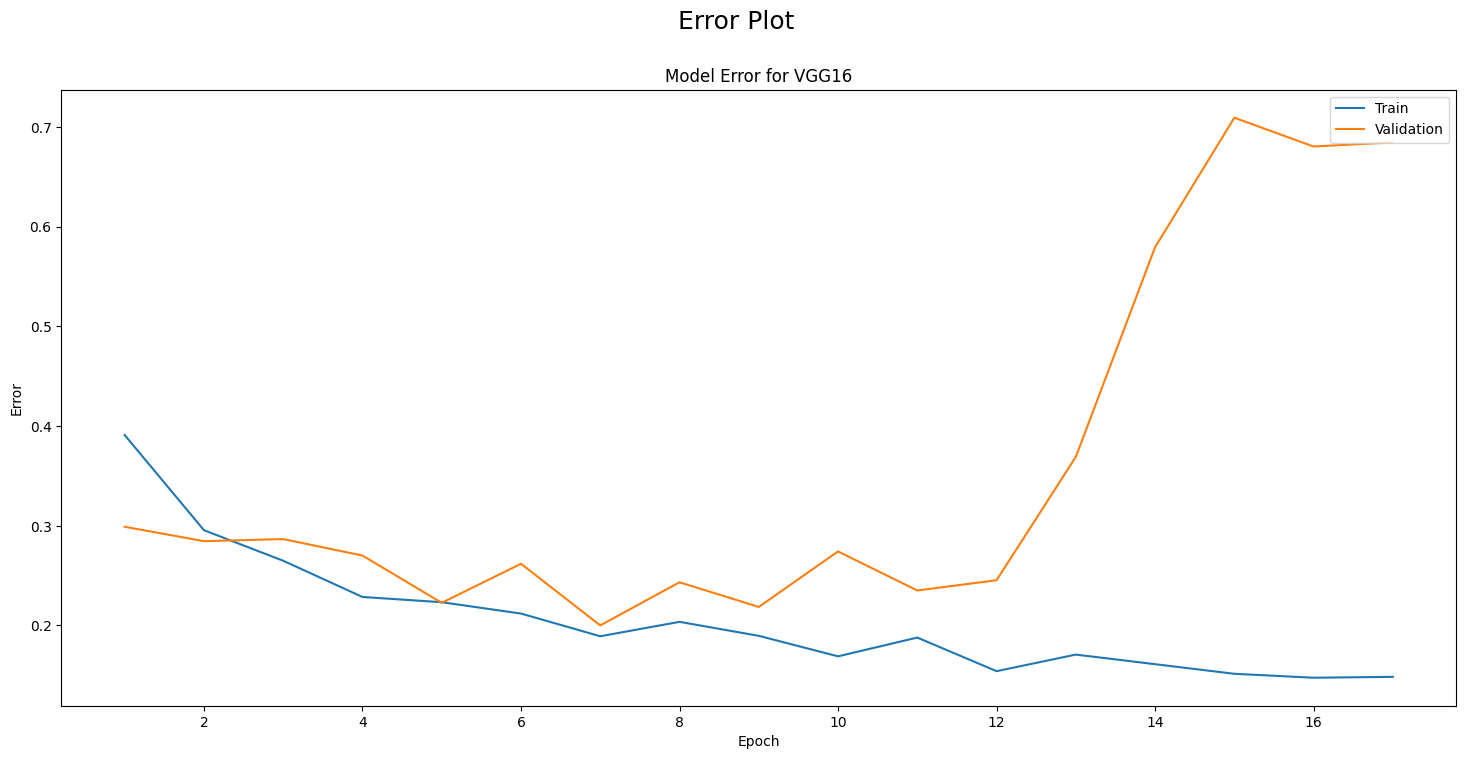

In [18]:
plt.figure(figsize=(18,8))

plt.suptitle('Error Plot', fontsize=18)

a=[1-x for x in clf.history['accuracy']]
b=[1-x for x in clf.history['val_accuracy']]

plt.plot(range(1,len(a)+1),a)
plt.plot(range(1,len(b)+1),b)
plt.title('Model Error for VGG16')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')


In [19]:
predictions = np.argmax(model.predict(test_values), axis=-1)

99/99 [==============================] - 4s 34ms/step


In [20]:
test_values.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [21]:
predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 3, 0, 0, 0, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 1, 2, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 4, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 0, 1, 1, 4, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 3, 4, 1, 1, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       4, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 4, 0, 2, 2, 2, 2, 0, 4, 2, 2, 2, 2, 3, 2, 4, 2, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 0, 2, 1, 2, 2, 1, 2, 3, 2,
       0, 3, 2, 2, 2, 2, 2, 2, 2, 0, 0, 4, 2, 2, 2, 2, 3, 3, 3, 3, 2, 3,
       3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [22]:
print(classification_report(test_values.classes, predictions))

              precision    recall  f1-score   support

           0       0.74      0.86      0.79       111
           1       0.79      0.85      0.82        74
           2       0.88      0.76      0.81        95
           3       0.86      0.88      0.87       108
           4       0.89      0.79      0.84       107

    accuracy                           0.83       495
   macro avg       0.83      0.83      0.83       495
weighted avg       0.83      0.83      0.83       495



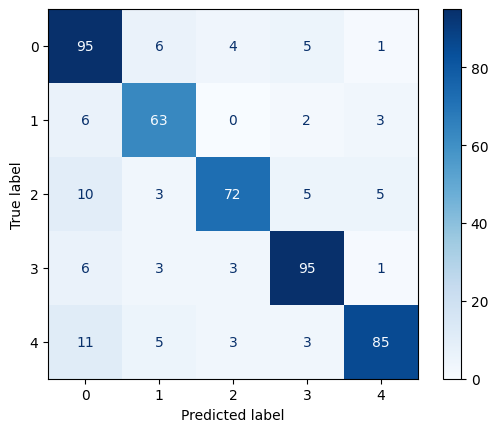

In [49]:
vgg_cm = confusion_matrix(test_values.classes, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=vgg_cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### EfficientNetB0 Model

In [23]:
effnet = EfficientNetB0(input_shape = (224,224,3), weights = 'imagenet', include_top = False)

for layer in effnet.layers:
    layer.trainable=False

model1 = tf.keras.models.Sequential([
        effnet,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1024, activation ='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(5, activation='softmax')
])

16705208/16705208 [==============================] - 2s 0us/step


In [24]:
model1.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['accuracy',Precision(),Recall()])

In [25]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 flatten_1 (Flatten)         (None, 62720)             0         
                                                                 
 batch_normalization_2 (Batc  (None, 62720)            250880    
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 62720)             0         
                                                                 
 dense_2 (Dense)             (None, 1024)              64226304  
                                                                 
 batch_normalization_3 (Batc  (None, 1024)             4096      
 hNormalization)                                      

In [26]:
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10, restore_best_weights=True)

In [27]:
clf1=model1.fit(train_values,epochs=100,callbacks=[early_stop],validation_data=(val_values),batch_size=5)

Epoch 1/100
457/457 [==============================] - 69s 132ms/step - loss: 1.3638 - accuracy: 0.6756 - precision_1: 0.6924 - recall_1: 0.6664 - val_loss: 0.4085 - val_accuracy: 0.8763 - val_precision_1: 0.8884 - val_recall_1: 0.8701
Epoch 2/100
457/457 [==============================] - 50s 109ms/step - loss: 0.6604 - accuracy: 0.7877 - precision_1: 0.8119 - recall_1: 0.7671 - val_loss: 0.3418 - val_accuracy: 0.9134 - val_precision_1: 0.9226 - val_recall_1: 0.9093
Epoch 3/100
457/457 [==============================] - 48s 105ms/step - loss: 0.5725 - accuracy: 0.8231 - precision_1: 0.8374 - recall_1: 0.8052 - val_loss: 0.2406 - val_accuracy: 0.9278 - val_precision_1: 0.9312 - val_recall_1: 0.9216
Epoch 4/100
457/457 [==============================] - 47s 102ms/step - loss: 0.4748 - accuracy: 0.8389 - precision_1: 0.8607 - recall_1: 0.8253 - val_loss: 0.3051 - val_accuracy: 0.9113 - val_precision_1: 0.9181 - val_recall_1: 0.9010
Epoch 5/100
457/457 [==============================] - 4

### Plots for EfficientNetB0 Model

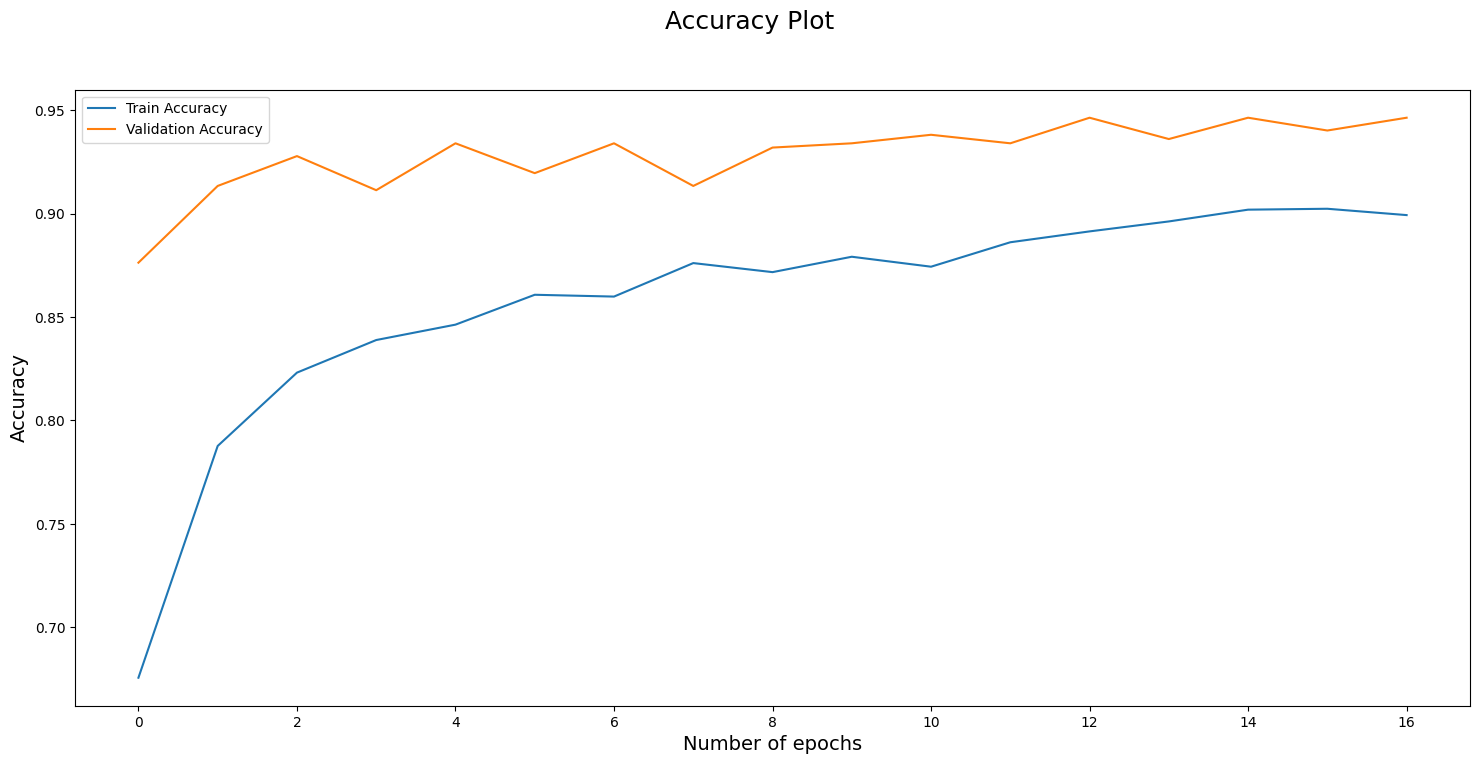

In [28]:
plt.figure(figsize=(18,8))

plt.suptitle('Accuracy Plot', fontsize=18)

plt.plot(clf1.history['accuracy'], label='Train Accuracy')
plt.plot(clf1.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Number of epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.show()

Text(0, 0.5, 'Loss')

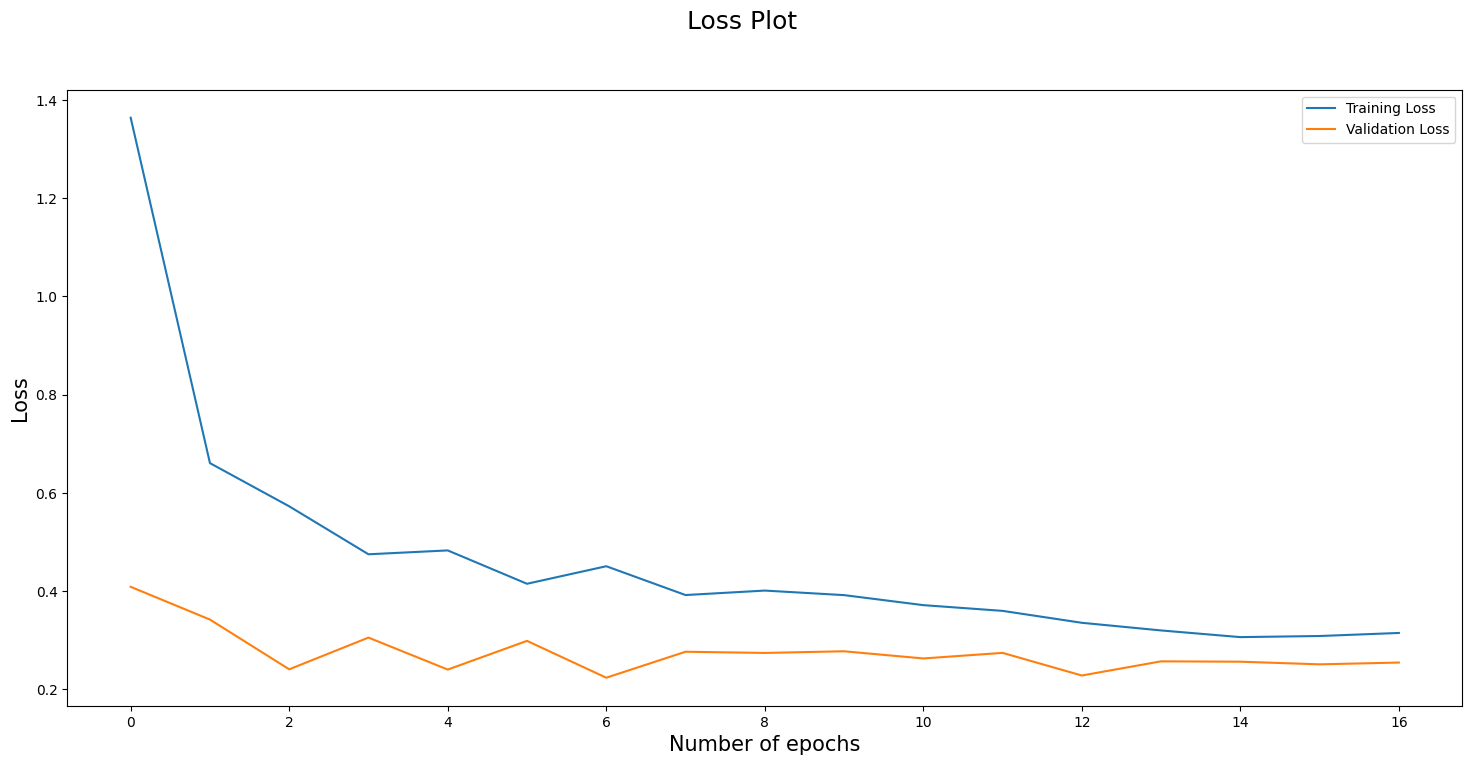

In [29]:
plt.figure(figsize=(18,8))

plt.suptitle('Loss Plot', fontsize=18)
plt.plot(clf1.history['loss'], label='Training Loss')
plt.plot(clf1.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Number of epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)

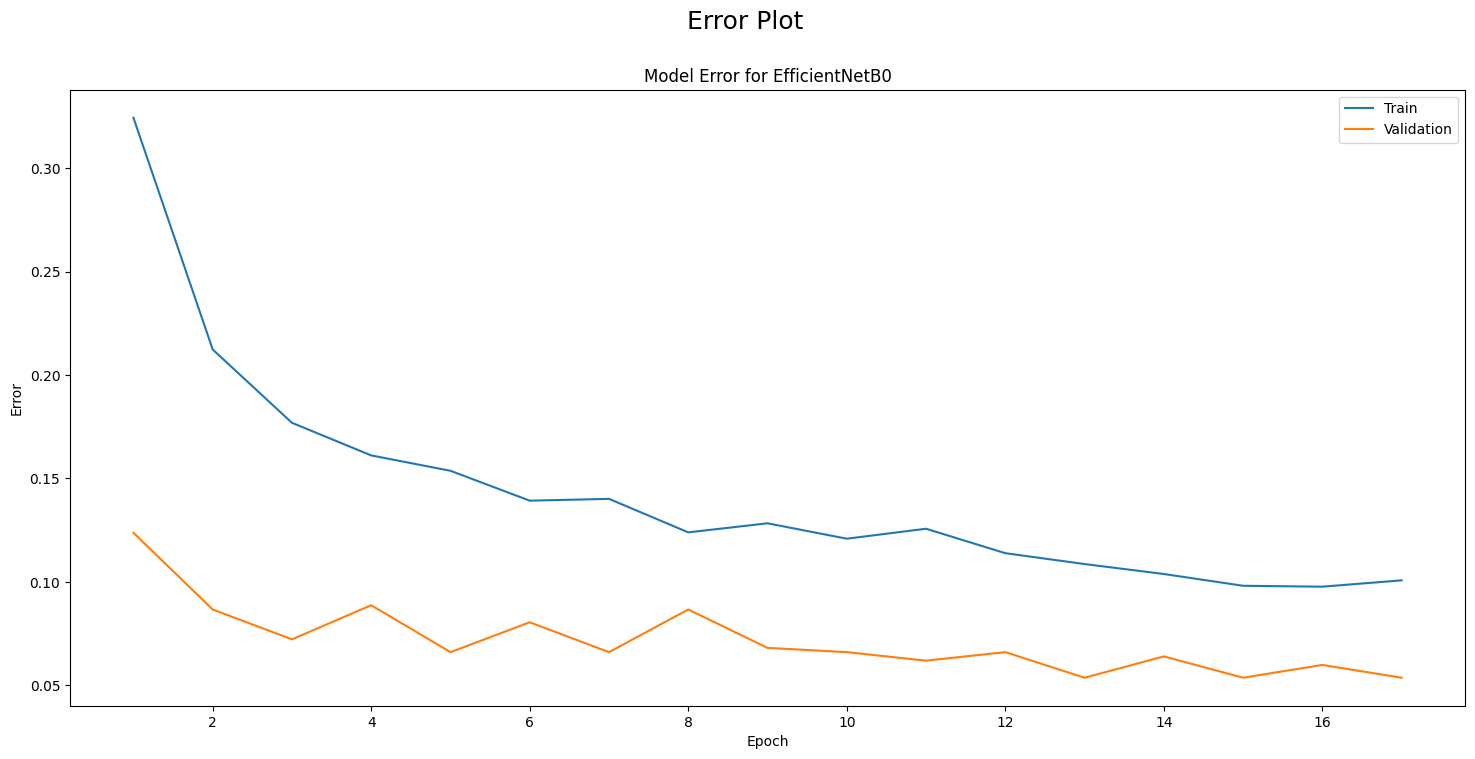

In [30]:
plt.figure(figsize=(18,8))

plt.suptitle('Error Plot', fontsize=18)

a=[1-x for x in clf1.history['accuracy']]
b=[1-x for x in clf1.history['val_accuracy']]

plt.plot(range(1,len(a)+1),a)
plt.plot(range(1,len(b)+1),b)
plt.title('Model Error for EfficientNetB0')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

In [31]:
predictions1 = np.argmax(model1.predict(test_values), axis=-1)

99/99 [==============================] - 5s 40ms/step


In [32]:
print(classification_report(test_values.classes, predictions1))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       111
           1       0.94      0.92      0.93        74
           2       0.93      0.91      0.92        95
           3       0.94      0.96      0.95       108
           4       0.93      0.94      0.94       107

    accuracy                           0.94       495
   macro avg       0.94      0.94      0.94       495
weighted avg       0.94      0.94      0.94       495



In [33]:
predictions1

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 4, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 4, 4, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 4, 4, 2, 2, 2, 2, 2, 2,
       0, 3, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

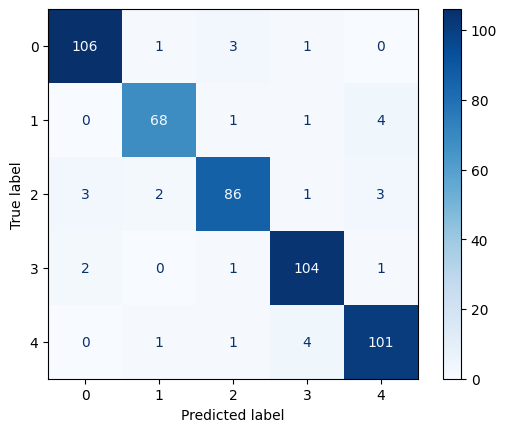

In [50]:
eff_cm = confusion_matrix(test_values.classes, predictions1)
disp = ConfusionMatrixDisplay(confusion_matrix=eff_cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### ResNet50 Model

In [34]:
resnet = ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

for layer in resnet.layers:
    layer.trainable = False

model2 = tf.keras.models.Sequential([
    resnet,
    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation='softmax')
])


94765736/94765736 [==============================] - 5s 0us/step


In [35]:
model2.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['accuracy',Precision(),Recall()])

In [36]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 batch_normalization_4 (Batc  (None, 100352)           401408    
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 100352)            0         
                                                                 
 dense_4 (Dense)             (None, 1024)              102761472 
                                                                 
 batch_normalization_5 (Batc  (None, 1024)             4096      
 hNormalization)                                      

In [37]:
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10, restore_best_weights=True)

In [38]:
clf2=model2.fit(train_values,epochs=100,callbacks=[early_stop],validation_data=(val_values),batch_size=5)

Epoch 1/100
457/457 [==============================] - 57s 110ms/step - loss: 1.6120 - accuracy: 0.6270 - precision_2: 0.6402 - recall_2: 0.6068 - val_loss: 1.5993 - val_accuracy: 0.6701 - val_precision_2: 0.6786 - val_recall_2: 0.6660
Epoch 2/100
457/457 [==============================] - 49s 106ms/step - loss: 0.7836 - accuracy: 0.7386 - precision_2: 0.7657 - recall_2: 0.7141 - val_loss: 1.2506 - val_accuracy: 0.7423 - val_precision_2: 0.7448 - val_recall_2: 0.7340
Epoch 3/100
457/457 [==============================] - 49s 107ms/step - loss: 0.6801 - accuracy: 0.7723 - precision_2: 0.7995 - recall_2: 0.7456 - val_loss: 1.2687 - val_accuracy: 0.7072 - val_precision_2: 0.7158 - val_recall_2: 0.7010
Epoch 4/100
457/457 [==============================] - 50s 108ms/step - loss: 0.6280 - accuracy: 0.7850 - precision_2: 0.8099 - recall_2: 0.7609 - val_loss: 0.9571 - val_accuracy: 0.7794 - val_precision_2: 0.7890 - val_recall_2: 0.7711
Epoch 5/100
457/457 [==============================] - 5

### Plots for ResNet50 Model

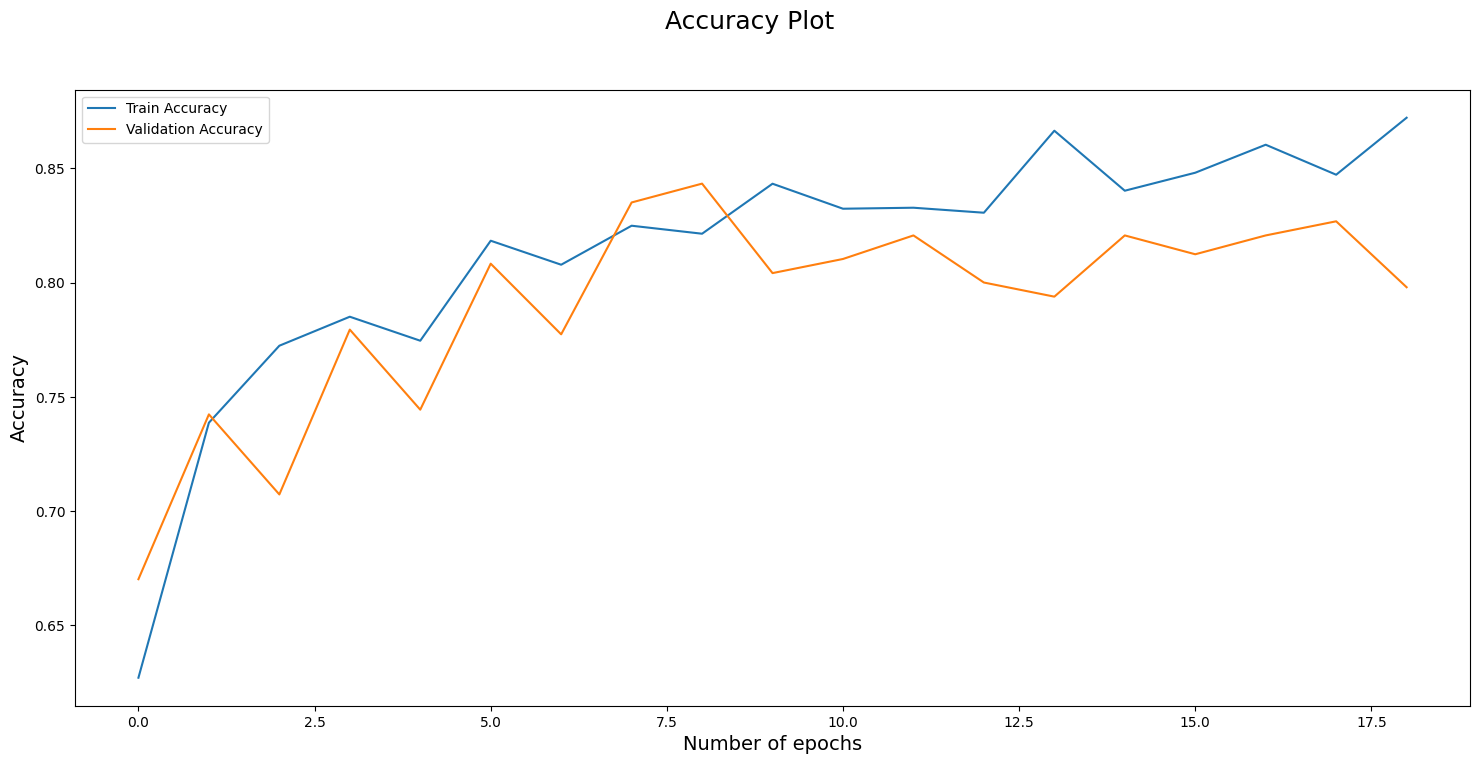

In [39]:
plt.figure(figsize=(18,8))

plt.suptitle('Accuracy Plot', fontsize=18)

plt.plot(clf2.history['accuracy'], label='Train Accuracy')
plt.plot(clf2.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Number of epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.show()

Text(0, 0.5, 'Loss')

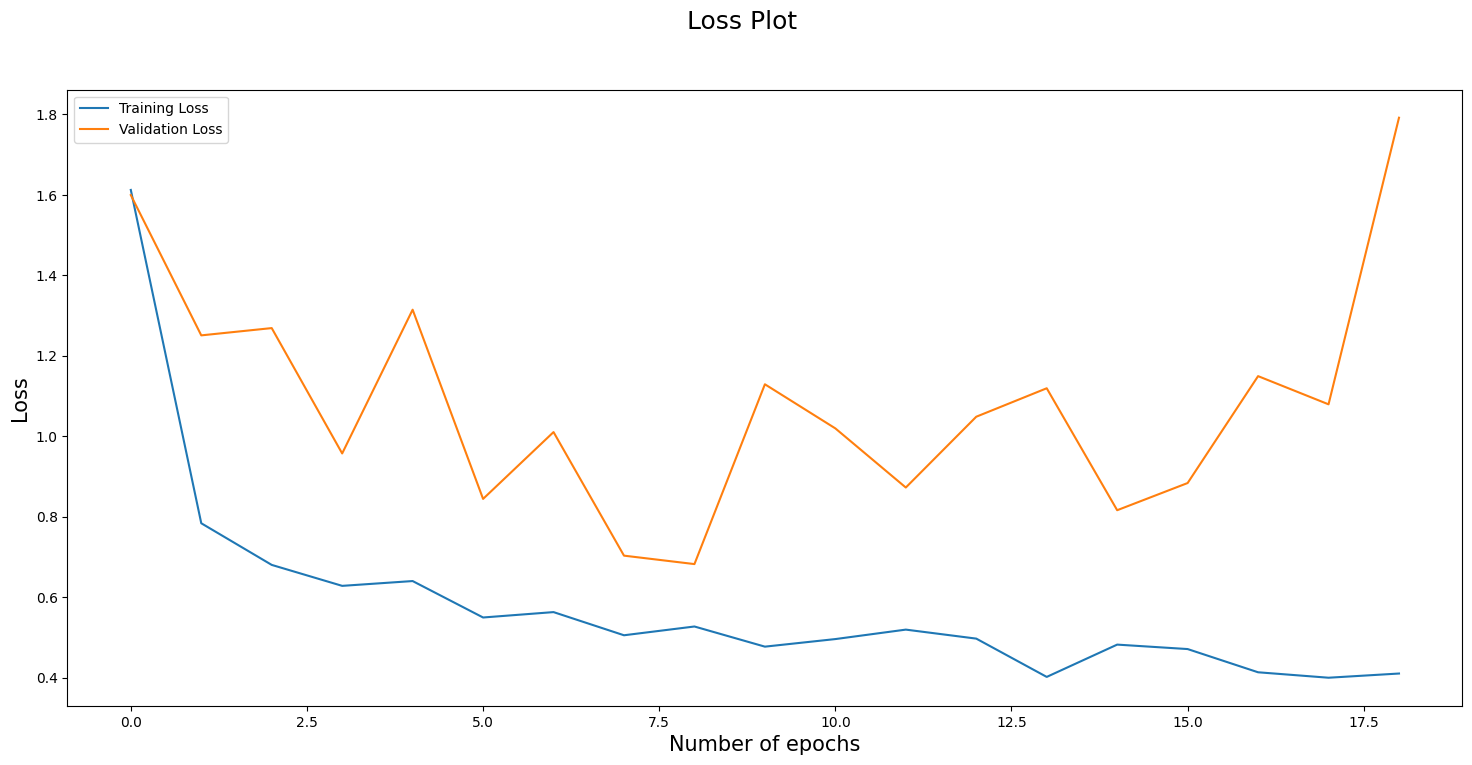

In [40]:
plt.figure(figsize=(18,8))

plt.suptitle('Loss Plot', fontsize=18)
plt.plot(clf2.history['loss'], label='Training Loss')
plt.plot(clf2.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Number of epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)

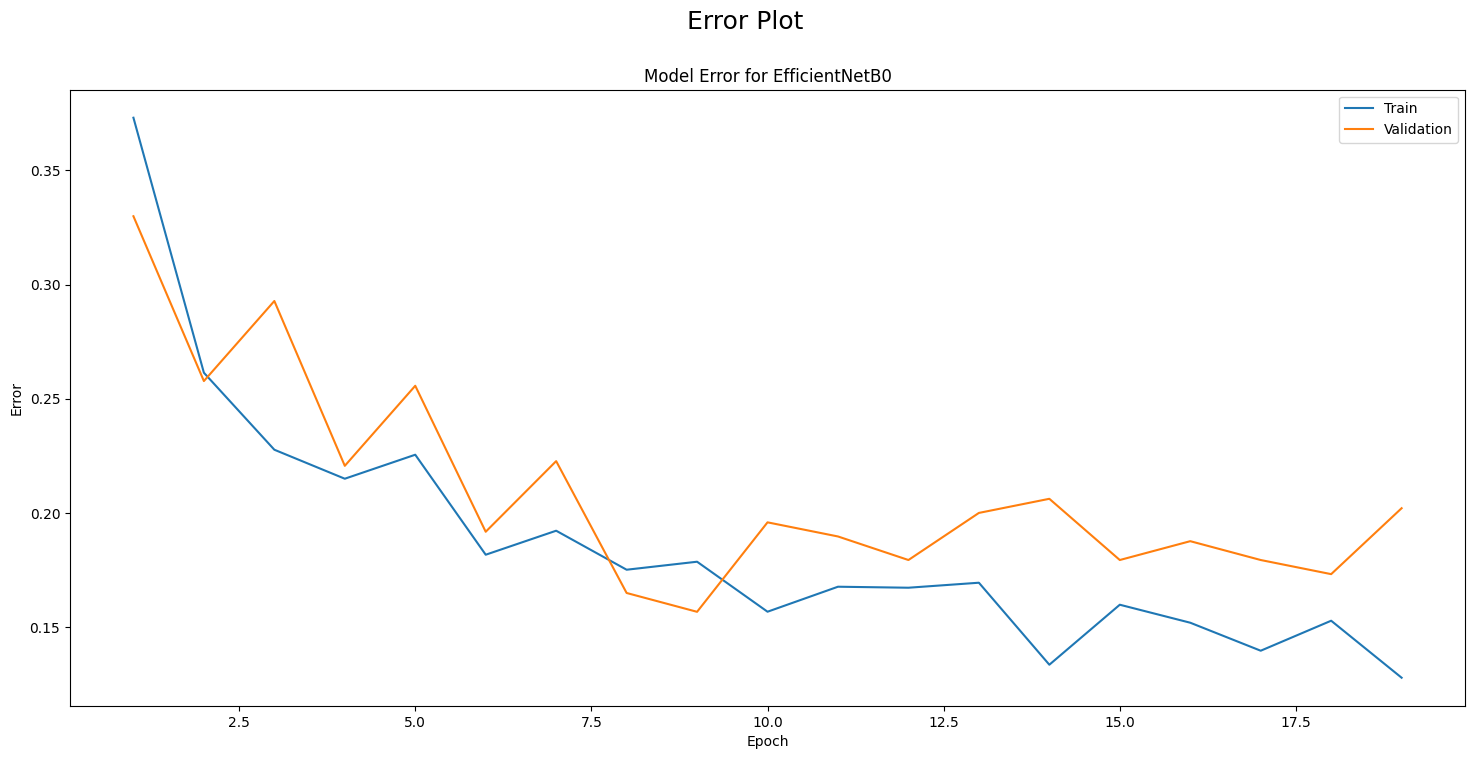

In [41]:
plt.figure(figsize=(18,8))

plt.suptitle('Error Plot', fontsize=18)

a=[1-x for x in clf2.history['accuracy']]
b=[1-x for x in clf2.history['val_accuracy']]

plt.plot(range(1,len(a)+1),a)
plt.plot(range(1,len(b)+1),b)
plt.title('Model Error for EfficientNetB0')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

In [42]:
predictions2 = np.argmax(model2.predict(test_values), axis=-1)

99/99 [==============================] - 4s 31ms/step


In [43]:
print(classification_report(test_values.classes, predictions2))

              precision    recall  f1-score   support

           0       0.88      0.81      0.85       111
           1       0.74      0.89      0.81        74
           2       0.78      0.84      0.81        95
           3       0.82      0.88      0.85       108
           4       0.92      0.73      0.81       107

    accuracy                           0.83       495
   macro avg       0.83      0.83      0.82       495
weighted avg       0.83      0.83      0.83       495



In [44]:
predictions2

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 3, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0,
       0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 3, 2, 0, 0, 0, 3, 0, 0, 0, 0,
       0, 0, 0, 0, 3, 0, 1, 2, 3, 0, 2, 0, 0, 3, 0, 0, 4, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 4, 1, 0, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 4, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 0, 2, 2,
       2, 2, 2, 2, 3, 2, 2, 2, 2, 3, 4, 2, 2, 2, 4, 2, 2, 2, 2, 2, 4, 2,
       2, 3, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

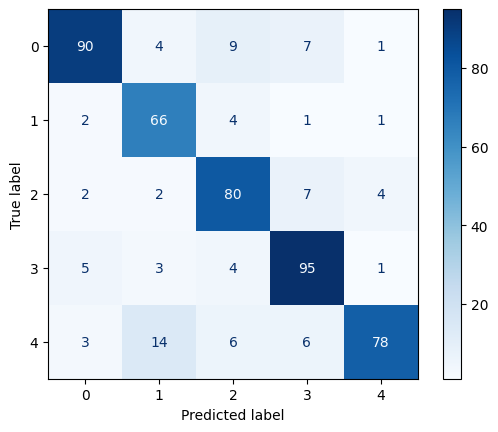

In [51]:
res_cm = confusion_matrix(test_values.classes, predictions2)
disp = ConfusionMatrixDisplay(confusion_matrix=res_cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

### Video Classification

In [53]:
model1.fit(val_values,epochs=100,callbacks=[early_stop],validation_data=(test_values),batch_size=5)

Epoch 1/100
97/97 [==============================] - 8s 86ms/step - loss: 2.7428 - accuracy: 0.2351 - precision_1: 0.2410 - recall_1: 0.1649 - val_loss: 1.0336 - val_accuracy: 0.6364 - val_precision_1: 0.7106 - val_recall_1: 0.5010
Epoch 2/100
97/97 [==============================] - 6s 65ms/step - loss: 2.1053 - accuracy: 0.2289 - precision_1: 0.2543 - recall_1: 0.0907 - val_loss: 1.0377 - val_accuracy: 0.6909 - val_precision_1: 0.9015 - val_recall_1: 0.2404
Epoch 3/100
97/97 [==============================] - 7s 75ms/step - loss: 1.7887 - accuracy: 0.1773 - precision_1: 0.2308 - recall_1: 0.0309 - val_loss: 1.0848 - val_accuracy: 0.7313 - val_precision_1: 0.9531 - val_recall_1: 0.1232
Epoch 4/100
97/97 [==============================] - 8s 88ms/step - loss: 1.6768 - accuracy: 0.2124 - precision_1: 0.5000 - recall_1: 0.0247 - val_loss: 1.1496 - val_accuracy: 0.6788 - val_precision_1: 0.9677 - val_recall_1: 0.0606
Epoch 5/100
97/97 [==============================] - 9s 94ms/step - loss

In [54]:
def extract_frames(video_path, L):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    indices = np.linspace(0, total_frames - 1,L).astype(int)
    frames = []
    for index in indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, index)
        ret, frame = cap.read()
        if ret:
            frame = cv2.resize(frame, (224, 224))
            frames.append(frame)
    
    cap.release()
    
    return np.array(frames)

In [55]:
data='../Data/Sport Videos/'
video_dir=os.listdir(data)
predY=[]
trueY=[]
video_path=[]
for i in video_dir:
    k = os.listdir(data+i)
    for j in k:
        video_path.append(data+i+'/'+j)
np.random.shuffle(video_path)
for i in video_path:
        frames=extract_frames(i,100)
        predictions_vid=model1.predict(frames)
        predY.append(predictions_vid.mean(axis=0).argmax(axis=0))
        trueY.append(i.split('/')[-2])
trueY=[0 if x=='BaseballPitch' else 1 if x=='Basketball' else 2 if x=='VolleyballSpiking' else 3 if x=='Fencing' else 4 for x in trueY]

4/4 [==============================] - 0s 53ms/step


In [56]:
print(classification_report(trueY, predY))

              precision    recall  f1-score   support

           0       0.68      0.33      0.45       150
           1       0.37      0.05      0.09       137
           2       0.25      0.47      0.32       116
           3       0.06      0.12      0.08       111
           4       0.23      0.22      0.22       167

    accuracy                           0.24       681
   macro avg       0.32      0.24      0.23       681
weighted avg       0.33      0.24      0.24       681



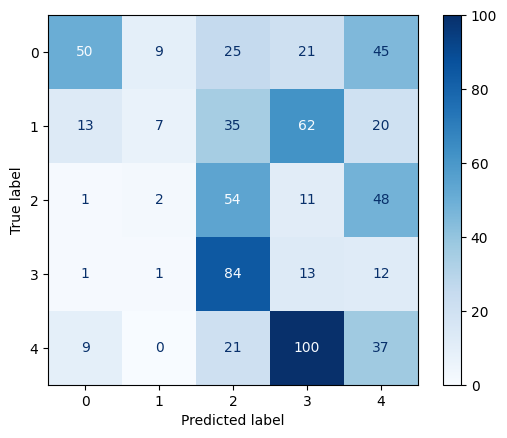

In [57]:
effn_cm = confusion_matrix(trueY, predY)
disp = ConfusionMatrixDisplay(confusion_matrix=effn_cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()